# 🟦 miniROS — Notebook 5
## Navigation Pipeline: Goals, Planning, Obstacle Avoidance & Safety Layer

This notebook puts everything together into a simple **navigation pipeline**:

- A **GoalManagerNode** that publishes a sequence of waypoints (`/goal`).
- A **GoToGoalNode** that:
  - reads `/goal`,
  - reads the robot pose,
  - computes a proportional control law for `cmd_vel`,
  - reads `/scan` and uses a smooth repulsive field to avoid obstacles,
  - applies a **geometric safety layer**: if the next pose would enter an obstacle, it **stops and rotates left** until safe.

This mimics a simplified ROS navigation stack:
- global planner (waypoints),
- local planner (go-to-goal + obstacle avoidance),
- safety layer (hard collision avoidance).


## Step 1 — Download miniROS from GitHub


In [1]:
!rm -rf miniROS
!git clone https://github.com/eder1234/miniROS.git
print("miniROS downloaded.")

Cloning into 'miniROS'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 68 (delta 32), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (68/68), 17.60 KiB | 8.80 MiB/s, done.
Resolving deltas: 100% (32/32), done.
miniROS downloaded.


## Step 2 — Imports
Import the simulator, robot, lidar, obstacles, Node, and messages.


In [2]:
import sys, math
sys.path.append('/content/miniROS')

import numpy as np
import matplotlib.pyplot as plt

from core.simulator import MiniRosSimulator
from robots.diffdrive import DiffDriveRobot
from sensors.lidar import Lidar2D
from world.obstacles import CircleObstacle
from core.messages import Pose2D, Twist
from core.node import Node

print("Imports OK.")

Imports OK.


## Step 3 — Build the world (robot, obstacles, lidar)

We create a small environment with obstacles and a lidar-equipped robot.


In [3]:
sim = MiniRosSimulator(dt=0.05)

robot = DiffDriveRobot(init_pose=Pose2D(0, 0, 0), radius=0.2, cmd_topic="/cmd_vel")
sim.add_robot(robot)

# Obstacles in the environment
obstacles = [
    CircleObstacle(1.5, 0.0, 0.4),
    CircleObstacle(1.5, 1.0, 0.4),
    CircleObstacle(0.0, 1.8, 0.4),
    CircleObstacle(-1.0, 0.8, 0.4)
]

lidar = Lidar2D(robot, obstacles, num_beams=72, max_range=4.0)
sim.add_lidar(lidar)

print("World initialized.")

World initialized.


## Step 4 — GoalManagerNode (sequence of waypoints)

This node publishes a list of waypoints one by one on the `/goal` topic.

- When the robot is close enough to the current goal, it switches to the next.
- Goals are `Pose2D` messages.


In [4]:
class GoalManagerNode(Node):
    def __init__(self, waypoints, tol=0.2):
        super().__init__("goal_manager")
        self.waypoints = waypoints
        self.current_idx = 0
        self.tol = tol
        self.topic = "/goal"

    def step(self, dt):
        if self.current_idx >= len(self.waypoints):
            # No more goals, keep publishing last one
            goal = self.waypoints[-1]
            self.publish(self.topic, goal)
            return

        goal = self.waypoints[self.current_idx]
        self.publish(self.topic, goal)

        # Check distance to current goal
        robot = self._sim.robots[0]
        dx = goal.x - robot.pose.x
        dy = goal.y - robot.pose.y
        dist = math.sqrt(dx*dx + dy*dy)

        if dist < self.tol:
            self.current_idx += 1

# Define a simple route (waypoints)
waypoints = [
    Pose2D(1.0, 0.0, 0.0),
    Pose2D(1.0, 1.5, 0.0),
    Pose2D(-0.5, 1.5, 0.0),
    Pose2D(-0.5, 0.0, 0.0)
]

goal_manager = GoalManagerNode(waypoints)
sim.add_node(goal_manager)

print("GoalManagerNode added.")

GoalManagerNode added.


## Step 5 — GoToGoalNode with Smooth Obstacle Avoidance + Safety Layer

This node:
- Subscribes to `/goal`.
- Computes a proportional go-to-goal command.
- Subscribes to `/scan` and uses a **repulsive field** (soft avoidance).
- Uses a **geometric safety check**: if the next pose (after applying `v,w`) would enter any obstacle, the robot **stops and rotates left** until safe.


In [5]:
def wrap_angle(angle):
    return (angle + math.pi) % (2 * math.pi) - math.pi

class GoToGoalNode(Node):
    """Robust navigation node with smooth obstacle avoidance and a hard safety layer."""

    def __init__(self, obstacles, kv=0.9, kw=2.0, safe_dist=0.7):
        super().__init__("go_to_goal")
        self.obstacles = obstacles
        self.kv = kv
        self.kw = kw
        self.safe_dist = safe_dist
        self.goal_tol = 0.10
        self.cmd_topic = "/cmd_vel"
        self.goal_topic = "/goal"
        self.scan_topic = "/scan"
        self.margin = 0.02  # safety margin (m)

    def will_collide_next_step(self, robot, v, w, dt):
        """Check if applying (v,w) for dt would place the robot inside any obstacle."""
        # approximate next pose using unicycle model
        x = robot.pose.x
        y = robot.pose.y
        yaw = robot.pose.yaw

        x_next = x + v * math.cos(yaw) * dt
        y_next = y + v * math.sin(yaw) * dt

        for obs in self.obstacles:
            d = math.sqrt((x_next - obs.x)**2 + (y_next - obs.y)**2)
            if d < (obs.radius + robot.radius + self.margin):
                return True
        return False

    def step(self, dt):
        robot = self._sim.robots[0]
        goal = self.read_topic(self.goal_topic)
        scan = self.read_topic(self.scan_topic)

        if goal is None:
            self.publish(self.cmd_topic, Twist(0.0, 0.0))
            return

        # ---- Go-to-goal control ----------------------------------
        dx = goal.x - robot.pose.x
        dy = goal.y - robot.pose.y
        dist = math.sqrt(dx*dx + dy*dy)

        if dist < self.goal_tol:
            self.publish(self.cmd_topic, Twist(0.0, 0.0))
            return

        angle_to_goal = math.atan2(dy, dx)
        heading_error = wrap_angle(angle_to_goal - robot.pose.yaw)

        v_goal = self.kv * dist
        w_goal = self.kw * heading_error

        # ---- Obstacle repulsion (smooth) -------------------------
        repulse_v = 0.0
        repulse_w = 0.0

        if scan is not None:
            ranges = np.array(scan.ranges)
            n = len(ranges)
            # Front sector ~60 degrees
            span = n // 12
            start = (n // 2) - span
            end   = (n // 2) + span
            front_ranges = ranges[start:end]

            min_front = np.min(front_ranges)

            if min_front < self.safe_dist:
                repulse_strength = (self.safe_dist - min_front) / self.safe_dist
                repulse_strength = float(np.clip(repulse_strength, 0.0, 1.0))

                # Reduce forward velocity proportionally
                repulse_v = -0.5 * repulse_strength

                # Turn away proportionally (bias to the left)
                repulse_w = +1.5 * repulse_strength

        # ---- Merge behaviors: goal + avoidance -------------------
        v = v_goal + repulse_v
        w = w_goal + repulse_w

        # ---- Clamp speeds for stability --------------------------
        v = float(np.clip(v, 0.0, 0.5))
        w = float(np.clip(w, -1.5, 1.5))

        # ---- HARD SAFETY LAYER -----------------------------------
        # If the next pose would enter an obstacle, stop and rotate left
        if self.will_collide_next_step(robot, v, w, dt):
            v = 0.0
            w = 1.0  # turn in place to the left until safe

        # ---- Publish command -------------------------------------
        self.publish(self.cmd_topic, Twist(v, w))

goto_goal = GoToGoalNode(obstacles=obstacles, kv=0.9, kw=2.0, safe_dist=0.7)
sim.add_node(goto_goal)

print("GoToGoalNode added.")

GoToGoalNode added.


## Step 6 — Run navigation for 35 seconds

The robot will:
- Receive sequential goals from `GoalManagerNode`.
- Try to reach each goal with the go-to-goal controller.
- Avoid obstacles using the smooth repulsive field.
- Never enter an obstacle thanks to the hard safety layer.


In [10]:
sim.run(35.0)
print("Navigation run complete.")

Navigation run complete.


## Step 7 — Visualize trajectory, obstacles, and waypoints


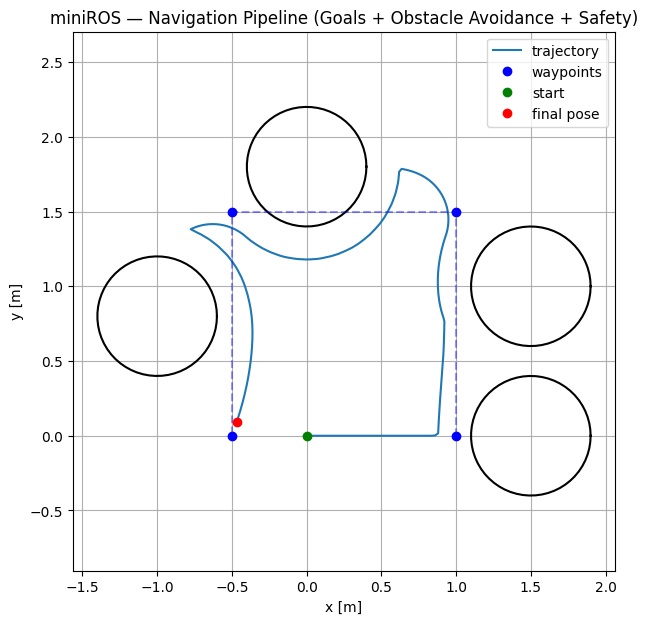

In [11]:
plt.figure(figsize=(7,7))

# Plot robot trajectory
plt.plot(robot.traj_x, robot.traj_y, '-', label='trajectory')

# Plot obstacles
theta = np.linspace(0, 2*np.pi, 60)
for obs in obstacles:
    plt.plot(obs.x + obs.radius * np.cos(theta),
             obs.y + obs.radius * np.sin(theta), 'k')

# Plot waypoints
wx = [wp.x for wp in waypoints]
wy = [wp.y for wp in waypoints]
plt.plot(wx, wy, 'bo', label='waypoints')
plt.plot(wx, wy, 'b--', alpha=0.4)

# Start and end markers
plt.plot(robot.traj_x[0], robot.traj_y[0], 'go', label='start')
plt.plot(robot.pose.x, robot.pose.y, 'ro', label='final pose')

plt.axis('equal')
plt.grid(True)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('miniROS — Navigation Pipeline (Goals + Obstacle Avoidance + Safety)')
plt.legend()
plt.show()

---
# 🧪 Exercises

1. Change the waypoint list to draw a different path (triangle, zigzag, etc.).
2. Tighten the safe distance and observe the effect on the trajectory.
3. Add more obstacles and see whether the robot still reaches all goals without collisions.
4. Modify the safety behavior so that, instead of always turning left, the robot decides left/right based on which side is farther from obstacles.
5. Split `GoToGoalNode` into two nodes: one for go-to-goal and one for obstacle avoidance that modifies `/cmd_vel`.

---
## End of Notebook 5 — Navigation Pipeline with Safety Layer

You now have a full miniROS teaching stack:
- Nodes, topics, and `cmd_vel`.
- Teleoperation.
- Lidar.
- Obstacle avoidance.
- Occupancy grid mapping.
- Navigation with goals, local planning, and a safety layer.
